In [1]:
%matplotlib inline
import time
import random
from random import shuffle
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import itertools
import logging

import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms, datasets, models
from torchvision.datasets import CIFAR10

from scipy.stats import entropy, ks_2samp
from scipy.special import kl_div
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import label_binarize

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import traceback
import copy

In [2]:
logname = 'logs/decentralized_multi_agent'
logging.basicConfig(filename=logname,
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG)

logging.info("Running Decentralized Learning test")

logger = logging.getLogger('Decentralized_log')

In [3]:
np.random.seed(0)

In [4]:
# Transformations
RC   = transforms.RandomCrop(32, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])

# Downloading/Louding CIFAR10 data
trainset = torchvision.datasets.CIFAR10(root='../data/cifar10', train=True,
                                        download=True, transform=transform_with_aug)

testset = torchvision.datasets.CIFAR10(root='../data/cifar10', train=False,
                                       download=True, transform=transform_no_aug)

classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

# Separating trainset/testset data/label
x_train  = trainset.data
x_test   = testset.data
y_train  = trainset.targets
y_test   = testset.targets

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc = transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# If we are saving a fraction
frac = int(len(x_train) * 0.05)
x_reserve = x_train[:frac]
y_reserve = y_train[:frac]
x_train = x_train[frac:]
y_train = y_train[frac:]

In [6]:
# ================== Usage ================== #

# 
trainset1 = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['plane']), 
         get_class_i(x_train, y_train, classDict['car']), 
         get_class_i(x_train, y_train, classDict['bird']),
        [],[],[],[],[],[],[]],
        transform_with_aug
    )
trainset2 = \
    DatasetMaker(
        [[],[],[],
         get_class_i(x_train, y_train, classDict['cat']), 
         get_class_i(x_train, y_train, classDict['deer']), 
         get_class_i(x_train, y_train, classDict['dog']), 
         [],[],[],[]],
        transform_with_aug
    )
trainset3 = \
    DatasetMaker(
        [[],[],[],[],[],[],
         get_class_i(x_train, y_train, classDict['frog']), 
         get_class_i(x_train, y_train, classDict['horse']), 
         get_class_i(x_train, y_train, classDict['ship']), 
         get_class_i(x_train, y_train, classDict['truck'])],
        transform_with_aug
    )
trainset4 = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['plane']), 
         get_class_i(x_train, y_train, classDict['car']), 
         get_class_i(x_train, y_train, classDict['bird']), 
         get_class_i(x_train, y_train, classDict['cat']), 
         get_class_i(x_train, y_train, classDict['deer']),
         get_class_i(x_train, y_train, classDict['dog']), 
         get_class_i(x_train, y_train, classDict['frog']), 
         get_class_i(x_train, y_train, classDict['horse']), 
         get_class_i(x_train, y_train, classDict['ship']), 
         get_class_i(x_train, y_train, classDict['truck'])],
        transform_with_aug
    )
reserved = \
    DatasetMaker(
        [get_class_i(x_reserve, y_reserve, classDict['plane']), 
         get_class_i(x_reserve, y_reserve, classDict['car']), 
         get_class_i(x_reserve, y_reserve, classDict['bird']), 
         get_class_i(x_reserve, y_reserve, classDict['cat']), 
         get_class_i(x_reserve, y_reserve, classDict['deer']),
         get_class_i(x_reserve, y_reserve, classDict['dog']), 
         get_class_i(x_reserve, y_reserve, classDict['frog']), 
         get_class_i(x_reserve, y_reserve, classDict['horse']), 
         get_class_i(x_reserve, y_reserve, classDict['ship']), 
         get_class_i(x_reserve, y_reserve, classDict['truck'])],
        transform_with_aug
    )
testset  = \
    DatasetMaker(
        [get_class_i(x_test, y_test, classDict['plane']), 
         get_class_i(x_test, y_test, classDict['car']), 
         get_class_i(x_test, y_test, classDict['bird']), 
         get_class_i(x_test, y_test, classDict['cat']), 
         get_class_i(x_test, y_test, classDict['deer']),
         get_class_i(x_test, y_test, classDict['dog']), 
         get_class_i(x_test, y_test, classDict['frog']), 
         get_class_i(x_test, y_test, classDict['horse']), 
         get_class_i(x_test, y_test, classDict['ship']), 
         get_class_i(x_test, y_test, classDict['truck'])],
        transform_no_aug
    )

superset = torch.utils.data.ConcatDataset([trainset3,reserved])

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader1   = DataLoader(trainset1, batch_size=64, shuffle=True , **kwargs)
trainsetLoader2   = DataLoader(trainset2, batch_size=64, shuffle=True , **kwargs)
trainsetLoader3   = DataLoader(trainset3, batch_size=64, shuffle=True , **kwargs)
trainsetLoader4   = DataLoader(trainset4, batch_size=64, shuffle=True , **kwargs)
reservedLoader    = DataLoader(superset, batch_size=64, shuffle=True , **kwargs)
testsetLoader    = DataLoader(testset , batch_size=64, shuffle=False, **kwargs)

In [7]:
def imshow(img):
    img = img / 2 + 0.3    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

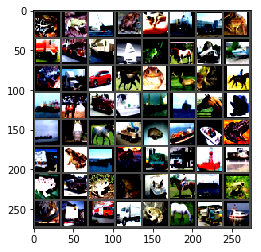

In [8]:
img, label = next(iter(reservedLoader))
imshow(torchvision.utils.make_grid(img))

In [9]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

# device2 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Decentralized model using reserved data

## Train a knowledge transfer model

In [10]:
def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d)):
        torch.nn.init.sparse_(m.weight, sparsity=0.33)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

class Decenter(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter, self).__init__()
        if len(shape) == 1:
            shape = shape[0]
            self.dim = 0
        elif len(shape) == 2:
            shape = shape[1]
            self.dim = 1
        self.translation = torch.nn.Sequential(
#             torch.nn.Tanh(),
            torch.nn.Linear(shape*2, shape)
        )

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source, target):
        x = torch.cat((source, target), self.dim)
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(target.shape)
        return res
    
    
class Interpolate(torch.nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = torch.nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode, align_corners=False)
        return x
    
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Decenter_pooled(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_pooled, self).__init__()
        self.shape = shape
        self.translation = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(channels_out),
            torch.nn.AdaptiveAvgPool2d(1),
#             Interpolate(size=1, mode='bilinear'),
            Reshape(shape[0], shape[1]*2),
            torch.nn.Linear(shape[1]*2, shape[1]*shape[-1]*shape[-1]),
#             Reshape(shape[0], shape[1] ,1 ,1),
        )

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source, target):
        x = torch.cat((source, target), 1)
        res = self.translation(x)
        res = res.view(self.shape[0], self.shape[1], self.shape[2], self.shape[3])
        return res
    
    
class Decenter_conv(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_conv, self).__init__()
        channels_in = shape[1]*2
        channels_out = shape[1]
        self.translation = torch.nn.Sequential(
            torch.nn.BatchNorm2d(channels_in),
            torch.nn.Conv2d(channels_in, channels_out, 3, stride=1, padding=1)
#             torch.nn.ConvTranspose2d(channels_in, channels_out, 3, stride=1, padding=1)

        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source, target):
        x = torch.cat((source, target), 1)
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
        return res

In [11]:
grad_dict: dict = {}
def fc_hook(layer_name, grad_input, grad_output): 
    if layer_name not in grad_dict:
        grad_dict[layer_name] = {}
        grad_dict[layer_name]["grad_input"] = []
        grad_dict[layer_name]["grad_output"] = []
        grad_dict[layer_name]["labels"] = []
        
#     print(grad_input)
#     print(grad_output)
    grad_dict[layer_name]["grad_input"].append(grad_input[0].cpu().numpy())
    grad_dict[layer_name]["grad_output"].append(grad_output[0].cpu().numpy())
    
# def reserve_step(source, target):
    

matlst = []
fclst = []

def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    writer = SummaryWriter('runs/') 

    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = 0.0
    best_acc = 0.0
    dataset_sizes = {'trainA': len(dataloders['trainA'].sampler),
                     'trainB': len(dataloders['trainB'].sampler),
                     'trainC': len(dataloders['trainC'].sampler),
                     'reservedA': len(dataloders['reservedA'].sampler),
                     'reservedB': len(dataloders['reservedB'].sampler),
                     'reservedCA': len(dataloders['reservedCA'].sampler),
                     'reservedCB': len(dataloders['reservedCB'].sampler),
                     'validA': len(dataloders['validA'].sampler),
                     'validB': len(dataloders['validB'].sampler),
                     'validC': len(dataloders['validC'].sampler)}

    i = 0
    for epoch in range(num_epochs):
        for phase in ['trainA', 'validA', 'trainB', 'validB', 'trainC', 'validC', 'reservedCA', 'validC', 'reservedCB', 'validC']:
            if phase not in ['validA','validB','validC']:
                scheduler[phase].step()
                scheduler[phase].step()
                model[phase].train(True)
            else:
                model['trainA'].train(False)
                model['trainB'].train(False)
                model['trainC'].train(False)
            
            
            running_loss = 0.0
            running_corrects = 0
            
            if phase in ['reservedCA','reservedCB']:
                if phase == 'reservedCA':
                    sd = model[phase].state_dict()
                    for key, value in mdlzAC.items():
                        shape = model['trainC'].state_dict()[key].shape
                        mdl = value[1](shape).to(device)
                        checkpoint = torch.load(value[0])
                        mdl.load_state_dict(checkpoint['model_state_dict'])
                        mdl.eval()
                        sd[key] = mdl(copy.deepcopy(model['trainA'].state_dict()[key]), copy.deepcopy(model['trainC'].state_dict()[key]))
#                         torch.save({'model_state_dict': mdl.state_dict()}, value[0])
                        
                        if key == 'conv1.weight':
                            matlst.append(sd[key])
                        elif key == 'fc.weight':
                            fclst.append(sd[key])
                        
                    model[phase].load_state_dict(sd)
                elif phase == 'reservedCB':
                    sd = model[phase].state_dict()
                    for key, value in mdlzBC.items():
                        shape = model['trainC'].state_dict()[key].shape
                        mdl = value[1](shape).to(device)
                        checkpoint = torch.load(value[0])
                        mdl.load_state_dict(checkpoint['model_state_dict'])
                        
                        sd[key] = mdl(copy.deepcopy(model['trainB'].state_dict()[key]), copy.deepcopy(model['trainC'].state_dict()[key]))
#                         torch.save({'model_state_dict': mdl.state_dict()}, value[0])
                        
                        if key == 'conv1.weight':
                            matlst.append(sd[key])
                        elif key == 'fc.weight':
                            fclst.append(sd[key])
                        
                    model[phase].load_state_dict(sd)
                    
                    
            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer[phase].zero_grad()

                outputs = model[phase](inputs)
                _, preds = torch.max(outputs.data, 1)
                
                if phase in ['reservedCA','reservedCB']:
                    loss_a = criterion['trainC'](outputs, labels)
#                     batch_size = labels.shape[0]
#                     # Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
#                     y = labels.reshape(-1,1)
#                     # One hot encoding buffer that you create out of the loop and just keep reusing
#                     y_onehot = torch.FloatTensor(batch_size, 10).to(device)

#                     # In your for loop
#                     y_onehot.zero_()
#                     y_onehot.scatter_(1, y, 1)

                    if phase == 'reservedCA':
                        outputs2 = model['trainA'](inputs)
                    elif phase == 'reservedCB':
                        outputs2 = model['trainB'](inputs)
    
                    sm = torch.nn.Softmax(dim=1)
                    outputs = sm(outputs)
                    outputs2 = sm(outputs2)
                    loss_b = criterion[phase](outputs, outputs2)
                    loss = (loss_a + loss_b) / 2
                else:
                    loss = criterion[phase](outputs, labels)

                if phase not in ['validA','validB','validC']:
                    loss.backward()
                    optimizer[phase].step()
                    
                    if phase == 'reservedCA':
#                         loss_b.backward(retain_graph=False)
                        for key, value in mdlzAC.items():
                            shape = model['trainC'].state_dict()[key].shape
                            mdl = value[1](shape).to(device)
                            opti = torch.optim.AdamW(mdl.parameters(), lr=0.001, betas=(0.9, 0.999))
                            checkpoint = torch.load(value[0])
                            mdl.load_state_dict(checkpoint['model_state_dict'])
                            mdl.eval()
                            opti.load_state_dict(checkpoint['optimizer_state_dict'])
#                             opti.zero_grad()
                            opti.step()
                            torch.save({'model_state_dict': mdl.state_dict(),
                                        'optimizer_state_dict': opti.state_dict()},
                                       value[0])
        
                    elif phase == 'reservedCB':
#                         loss_b.backward(retain_graph=False)
                        for key, value in mdlzBC.items():
                            shape = model['trainC'].state_dict()[key].shape
                            mdl = value[1](shape).to(device)
                            opti = torch.optim.AdamW(mdl.parameters(), lr=0.001, betas=(0.9, 0.999))
                            checkpoint = torch.load(value[0])
                            mdl.load_state_dict(checkpoint['model_state_dict'])
                            mdl.eval()
                            opti.load_state_dict(checkpoint['optimizer_state_dict'])
#                             opti.zero_grad()
                            opti.step()
                            torch.save({'model_state_dict': mdl.state_dict(),
                                        'optimizer_state_dict': opti.state_dict()},
                                       value[0])
                    
                    ## Tensorboard
#                     writer.add_histogram('distribution centers/resnet2', model.fc.weight.cpu().detach().numpy(), i)
                    i+=1
                    ## Back prop hook
#                     grad_dict["fc"]["labels"].append(labels.cpu().numpy())

                
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
                
            if phase not in ['validA','validB','validC']:
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                print() 
                logger.info('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                
            if phase in ['validA','validB','validC'] and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model[phase].state_dict()

                
    print('Best val Acc: {:4f}'.format(best_acc))
    logger.info('Best val Acc: {:4f}'.format(best_acc))

    writer.close()
#     model.load_state_dict(best_model_wts)
    return model

In [12]:
resnetA = models.resnet18(pretrained=False)
resnetB = models.resnet18(pretrained=False)
resnetC = models.resnet18(pretrained=False)
# freeze all model parameters
# for param in resnet.parameters():
#     param.requires_grad = False

# new final layer with 16 classes
num_ftrsA = resnetA.fc.in_features
resnetA.fc = torch.nn.Linear(num_ftrsA, 10)

num_ftrsB = resnetB.fc.in_features
resnetB.fc = torch.nn.Linear(num_ftrsB, 10)

num_ftrsC = resnetC.fc.in_features
resnetC.fc = torch.nn.Linear(num_ftrsC, 10)

def fc_backward_hook(module, grad_input, grad_output):  # module is Linear in this case. Ignored.
        fc_hook("fc", grad_input, grad_output)
resnetA.fc_hook_handle = resnetA.fc.register_backward_hook(fc_backward_hook)
resnetB.fc_hook_handle = resnetB.fc.register_backward_hook(fc_backward_hook)
resnetC.fc_hook_handle = resnetC.fc.register_backward_hook(fc_backward_hook)


def roc_auc_score_micro(y_pred_proba, y_true):
    y_pred_proba = y_pred_proba.detach().cpu()
    y_true = y_true.detach().cpu()
    return metrics.roc_auc_score(
        label_binarize(y_true, classes=list(range(y_pred_proba.shape[1]))).ravel(),
        y_pred_proba.flatten())


resnetA = resnetA.to(device)
resnetB = resnetB.to(device)
resnetC = resnetC.to(device)

criterionA = torch.nn.CrossEntropyLoss()
# criterionB = torch.nn.CrossEntropyLoss()
# criterionA = torch.nn.KLDivLoss()
criterionB = torch.nn.KLDivLoss(reduction = 'batchmean')
# criterionB = torch.nn.KLDivLoss(reduction = 'mean')
# criterionB = torch.nn.MSELoss()
# optimizerA = torch.optim.SGD(resnetA.parameters(), lr=0.001, momentum=0.9)
# optimizerB = torch.optim.SGD(resnetB.parameters(), lr=0.001, momentum=0.9)
optimizerA = torch.optim.AdamW(resnetA.parameters(), lr=0.001, betas=(0.9, 0.999))
optimizerB = torch.optim.AdamW(resnetB.parameters(), lr=0.001, betas=(0.9, 0.999))
optimizerC = torch.optim.AdamW(resnetC.parameters(), lr=0.001, betas=(0.9, 0.999))

exp_lr_schedulerA = lr_scheduler.StepLR(optimizerA, step_size=20, gamma=0.1)
exp_lr_schedulerB = lr_scheduler.StepLR(optimizerB, step_size=20, gamma=0.1)
exp_lr_schedulerC = lr_scheduler.StepLR(optimizerC, step_size=20, gamma=0.1)


def hwout(Hin, padding, dilation, kernel_size, stride):
    return (Hin + 2 * padding - dilation * (kernel_size-1) - 1)/stride + 1

In [13]:
max_layer = 0
max_neurons = 0
for prm in resnetC.named_parameters():
    num_ftr = np.prod(prm[1].shape)
    if num_ftr > max_neurons:
         max_neurons = num_ftr
         max_layer = prm[1]

In [14]:
[x[0] for x in resnetC.named_parameters()]

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.downsample.0.weight',
 'layer2.0.downsample.1.weight',
 'layer2.0.downsample.1.bias',
 'layer2.1.conv1.weight',
 'layer2.1.bn1.weight',
 'layer2.1.bn1.bias',
 'layer2.1.conv2.weight',
 'layer2.1.bn2.weight',
 'layer2.1.bn2.bias',
 'layer3.0.conv1.weight',
 'layer3.0.bn1.weight',
 'layer3.0.bn1.bias',
 'layer3.0.conv2.weight',
 'layer3.0.bn2.weight',
 'layer3.0.bn2.bias',
 'layer3.0.downsample.0.weight',
 'layer3.0.downsample.1.weight',
 'layer3.0.downsample.1.bias',
 'layer3.1.conv1.weight',
 'layer3.1.bn1.

In [14]:
# %%timeit
mdlzAC = dict()
mdlzBC = dict()
params = []
model_dir = './multi_model_chain'
conv_layers = ['layer4.1.conv2.weight', 'layer4.1.conv1.weight', 'layer4.0.conv2.weight']
bn_layers = ['layer4.1.bn2.bias', 'layer4.1.bn2.weight',
             'layer4.1.bn1.bias', 'layer4.1.bn1.weight',
             'layer4.0.bn2.bias', 'layer4.0.bn2.weight',
             'layer4.0.downsample.0.weight', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias',
             'fc.weight', 'fc.bias']

for prm in resnetC.named_parameters():
# for prm in temp_list:
    if 'conv' in prm[0] or 'fc' in prm[0] or 'bn' in prm[0] or 'downsample' in prm[0]:
        try:
            if prm[1].dim() > 2:
                if prm[0] not in conv_layers:
                    continue
                mdl = Decenter_conv(prm[1].shape).to(device)
                optimizer = torch.optim.AdamW(mdl.parameters(), lr=0.001, betas=(0.9, 0.999))
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict()},
                           model_dir + '/' + prm[0]+'A')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict()},
                           model_dir + '/' + prm[0]+'B')
                mdlzAC[prm[0]] = (model_dir + '/' + prm[0]+'A', Decenter_conv)
                mdlzBC[prm[0]] = (model_dir + '/' + prm[0]+'B', Decenter_conv)
#                 params += mdl.parameters()
#                 pass
            else:
#                 if prm[0] not in bn_layers:
#                     continue
                mdl = Decenter(prm[1].shape).to(device)
                optimizer = torch.optim.AdamW(mdl.parameters(), lr=0.001, betas=(0.9, 0.999))
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict()},
                           model_dir + '/' + prm[0]+'A')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict()},
                           model_dir + '/' + prm[0]+'B')
                mdlzAC[prm[0]] = (model_dir + '/' + prm[0]+'A', Decenter)
                mdlzBC[prm[0]] = (model_dir + '/' + prm[0]+'B', Decenter)
#                 params += mdl.parameters()
            
            del mdl
            torch.cuda.empty_cache()
        except Exception as e:
            print("Problem with: " + prm[0] + " Size: " + str(num_ftr))
            print("Error: " + str(e))
            traceback.print_exc()
            print()
            pass
        
# params += list(resnetC.parameters())

# optimizerRB = torch.optim.SGD(params, lr=0.01, momentum=0.9)
optimizerRC = torch.optim.AdamW(resnetC.parameters(), lr=0.001, betas=(0.9, 0.999))

In [15]:
mdlzBC

{'bn1.weight': ('./multi_model_chain/bn1.weightB', __main__.Decenter),
 'bn1.bias': ('./multi_model_chain/bn1.biasB', __main__.Decenter),
 'layer1.0.bn1.weight': ('./multi_model_chain/layer1.0.bn1.weightB',
  __main__.Decenter),
 'layer1.0.bn1.bias': ('./multi_model_chain/layer1.0.bn1.biasB',
  __main__.Decenter),
 'layer1.0.bn2.weight': ('./multi_model_chain/layer1.0.bn2.weightB',
  __main__.Decenter),
 'layer1.0.bn2.bias': ('./multi_model_chain/layer1.0.bn2.biasB',
  __main__.Decenter),
 'layer1.1.bn1.weight': ('./multi_model_chain/layer1.1.bn1.weightB',
  __main__.Decenter),
 'layer1.1.bn1.bias': ('./multi_model_chain/layer1.1.bn1.biasB',
  __main__.Decenter),
 'layer1.1.bn2.weight': ('./multi_model_chain/layer1.1.bn2.weightB',
  __main__.Decenter),
 'layer1.1.bn2.bias': ('./multi_model_chain/layer1.1.bn2.biasB',
  __main__.Decenter),
 'layer2.0.bn1.weight': ('./multi_model_chain/layer2.0.bn1.weightB',
  __main__.Decenter),
 'layer2.0.bn1.bias': ('./multi_model_chain/layer2.0.bn1.bi

In [16]:
### Define phases 
dloaders = {'trainA':trainsetLoader1, 'trainB':trainsetLoader2, 'trainC':reservedLoader,
            'validA':testsetLoader, 'validB':testsetLoader, 'validC':testsetLoader,
            'reservedA':reservedLoader, 'reservedB':reservedLoader, 'reservedCA':reservedLoader, 'reservedCB':reservedLoader}
model = {'trainA':resnetA, 'trainB':resnetB, 'trainC':resnetC,
         'validA':resnetA, 'validB':resnetB, 'validC':resnetC,
         'reservedA':resnetA, 'reservedB':resnetB, 'reservedCA':resnetC, 'reservedCB':resnetC}
optimizer = {'trainA':optimizerA, 'trainB':optimizerB, 'trainC':optimizerC,
             'validA':optimizerA, 'validB':optimizerB, 'validC':optimizerC,
             'reservedA':optimizerA, 'reservedB':optimizerB, 'reservedCA':optimizerRC, 'reservedCB':optimizerRC}
criterion = {'trainA':criterionA, 'trainB':criterionA, 'trainC':criterionA,
             'validA':criterionA, 'validB':criterionA, 'validC':criterionA,
             'reservedA':criterionB, 'reservedB':criterionB, 'reservedCA':criterionB, 'reservedCB':criterionB}
exp_lr_scheduler = {'trainA':exp_lr_schedulerA, 'trainB':exp_lr_schedulerB, 'trainC':exp_lr_schedulerC,
             'validA':exp_lr_schedulerA, 'validB':exp_lr_schedulerB, 'validC':exp_lr_schedulerC,
             'reservedA':exp_lr_schedulerA, 'reservedB':exp_lr_schedulerB, 'reservedCA':exp_lr_schedulerC, 'reservedCB':exp_lr_schedulerC}

In [17]:
logging.info("#### bn acti conv and fc - unlimited bn - adam learning rate 0.001 - scheduler 20 - opt adamw ####")

start_time = time.time()
model = train_model(dloaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=200)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

/home/ogoldstein/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch [0/199] phase: validA train loss: 0.0107 acc: 0.7201 valid loss: 0.1264 acc: 0.2393

Epoch [0/199] phase: validB train loss: 0.0152 acc: 0.5359 valid loss: 0.1070 acc: 0.1766

Epoch [0/199] phase: validC train loss: 0.0153 acc: 0.6876 valid loss: 0.0419 acc: 0.3074

Epoch [0/199] phase: validC train loss: 0.0020 acc: 0.7091 valid loss: 0.0362 acc: 0.3339

Epoch [0/199] phase: validC train loss: -0.0010 acc: 0.7680 valid loss: 0.0373 acc: 0.3383

Epoch [1/199] phase: validA train loss: 0.0074 acc: 0.8156 valid loss: 0.1322 acc: 0.2575

Epoch [1/199] phase: validB train loss: 0.0132 acc: 0.6034 valid loss: 0.1188 acc: 0.1897

Epoch [1/199] phase: validC train loss: 0.0098 acc: 0.8120 valid loss: 0.0347 acc: 0.3428

Epoch [1/199] phase: validC train loss: 0.0011 acc: 0.8078 valid loss: 0.0337 acc: 0.3603

Epoch [1/199] phase: validC train loss: -0.0014 acc: 0.8223 valid loss: 0.0312 acc: 0.3690

Epoch [2/199] phase: validA train loss: 0.0065 acc: 0.8349 valid loss: 0.1303 acc: 0.257

KeyboardInterrupt: 

## Testing ground

In [ ]:
### Test funciton on conv layers

A = list(resnetA.named_parameters())[-14][1]
B = list(resnetB.named_parameters())[-14][1]
x = torch.cat((A, B), 1)
x.shape

pool = torch.nn.AdaptiveAvgPool2d(1)
inter = Interpolate(size=(1), mode='bilinear')

px = pool(x)
ix = inter(x)